In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

confusion_matrix: 

# 加载数据

In [19]:
print( tf.__version__)

1.10.0


In [2]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [3]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [4]:
# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# 数据处理

## One-hot编码

In [5]:
data.y_test[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [6]:
data.y_test_cls[0:5]

array([7, 2, 1, 0, 4])

## 绘制图像

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

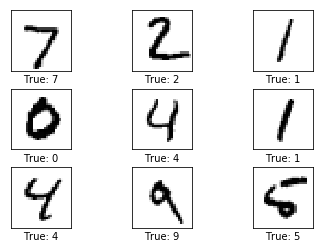

In [8]:
images = data.x_test[0:9]

cls_true = data.y_test_cls[0:9]

plot_images(images=images, cls_true=cls_true)

# Tensorflow图

包含信息：

1、图的输入：占位符变量 placeholder

2、模型变量：model 将会被优化，模型表现得更好

3、损失评估：cost度量指导变量的优化

4、优化方法：GD，更新模型的变量

## placeholder

作用：图的输入，每次运行图可能会改变

改变过程：feeding placeholder

类型：张量 —— 多维向量或矩阵

输入特征

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

输入标签One hot

In [10]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

真实标签 - placeholder变量

In [11]:
y_true_cls = tf.placeholder(tf.int64, [None])

## 需要优化的变量

初始化权重, 权重全部初始化为0

In [12]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

初始化偏差

In [13]:
biases = tf.Variable(tf.zeros([num_classes]))

## 模型


x(placeholder) * weight + biases

In [14]:
logits = tf.matmul(x, weights) + biases

softmax层：

由来：logits只表示第 i 行第 j 列的那个元素代表着第 i 张输入图像有多大可能性是第 j 个类别

效果：归一化，每个元素限制在0到1之间，每一行相加等于1

作用：多分类

In [15]:
y_pred = tf.nn.softmax(logits)

In [21]:
y_pred_cls = tf.arg_max(y_pred, dimension=1)

## 优化损失函数

损失函数：

交叉熵（cross-entropy），最小化交叉熵

In [22]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, 
                                                          labels=y_true)

所有图像分类交叉熵的均值

In [23]:
cost = tf.reduce_mean(cross_entropy)

## 优化方法

优化方法：梯度下降，步长=0.5

作用：往tensorflow图中添加优化器，以便之后的操作

In [24]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

## 性能度量

准确率ACC

In [25]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [26]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 运行Tensorflow

## 创建Tensorflow会话（session）

In [27]:
session = tf.Session()

## session 初始化所有变量

In [28]:
session.run(tf.global_variables_initializer())

## 优化迭代

问题：样本量有50000，太大，使用梯度下降花费较多时间

解决：采用 mini-batch 梯度下降的方法，在优化器的每次迭代中只用一小部分的图像

In [32]:
batch_size = 100

In [50]:
def optimize(num_iterations):
    for i in range(num_iterations):
        
        # 随机取训练样本，X_batch图片特征；Y_true_batch图片标签
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        # 为训练集设置feed字典
        feed_dict_train = {x: x_batch,
                          y_true: y_true_batch}
        # 增加训练集，运行优化器
        session.run(optimizer, feed_dict = feed_dict_train)

## 展示性能的帮助函数

为测试集设置feed字典

In [37]:
feed_dict_test = {x : data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

打印测试集分类准确度函数

In [38]:
def print_accuracy():
    
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    print("Accuracy on test-set: {0:.1%}".format(acc))

## 用sklearn打印混淆矩阵

In [40]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # 混淆矩阵：正确标签 + 预测标签
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## 绘制测试集中误分类的图像

In [42]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## 绘制模型权重的辅助函数

In [43]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# 开始尝试

In [45]:
print_accuracy()

Accuracy on test-set: 9.8%


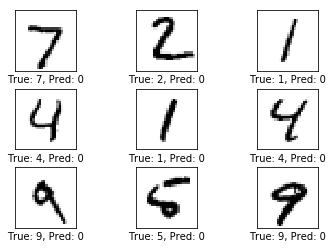

In [46]:
plot_example_errors()

迭代一次

In [51]:
optimize(num_iterations=1)

In [52]:
print_accuracy()

Accuracy on test-set: 28.5%


绘制权重：784 * 10

正值为红色，负值为蓝色

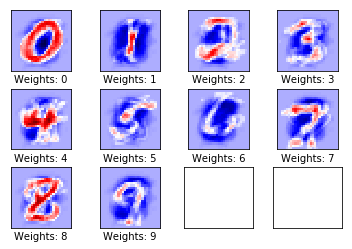

In [53]:
plot_weights()

多次迭代

In [54]:
optimize(num_iterations=9)

In [55]:
print_accuracy()

Accuracy on test-set: 83.2%


In [56]:
optimize(num_iterations=990)

In [58]:
print_accuracy()

Accuracy on test-set: 91.5%


权重w，对应识别为每个类别的概率

可以理解为图像滤波器

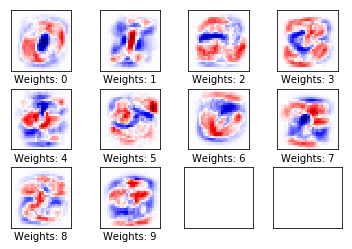

In [61]:
plot_weights()

混淆矩阵：

定义：

说明：


[[ 958    0    1    3    0    3    8    3    4    0]
 [   0 1099    2    2    0    2    4    2   24    0]
 [   8   10  877   28    8    2   10   16   62   11]
 [   4    0    7  929    0   24    1    8   26   11]
 [   2    3    6    2  872    1    9    2   16   69]
 [  12    3    2   42    6  753   16    8   43    7]
 [  14    3    4    2    9   16  904    3    3    0]
 [   2   10   17    9    5    1    0  943    6   35]
 [   8    6    4   21    7   21   10    9  884    4]
 [   9    5    2   11   13    6    0   21   13  929]]


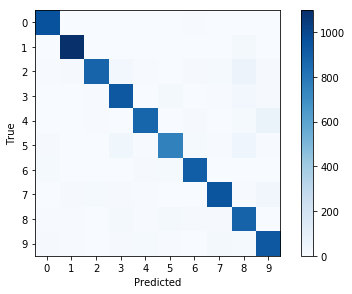

In [62]:
print_confusion_matrix()

# 关闭session，释放资源

In [63]:
session.close()

# 练习思考

1、